In [12]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import os

import pypolo2

dir = "./data/MyProData/Total1123.csv"

# Environment

In [13]:
Setting = pypolo2.utilities.Config()

In [14]:
# 初始时间数据选择从数据中读取的初始状态，选取11月23日
#读取数据
df_env = pd.read_csv(dir)
df_env_timeindex = df_env.set_index('time')

base_time = pd.Timestamp('2018-11-23 00:00:00')

# 选择时间段
start_time = pd.Timestamp('2018-11-23 08:00:00')
end_time = pd.Timestamp('2018-11-23 08:00:00')

#计算时间点
df_env['time_int'] = df_env['time'].apply(lambda x: round((pd.Timestamp(x) - base_time).total_seconds() / 60 / 10))

# 将 time 字段转换为 Pandas 中的 Timestamp 类型
df_env['time'] = pd.to_datetime(df_env['time'], format="%Y-%m-%d %H:%M:%S")

# 从 DataFrame 中选择符合时间段的数据
mask = (df_env['time'] >= start_time) & (df_env['time'] <= end_time)
selected_data = df_env.loc[mask]

data_x_env = selected_data.loc[:, ['lat_bin', 'lon_bin', 'time_int', 'time']].values
data_y_env = selected_data.loc[:, ['pm2d5', 'time_int', 'time']].values

data_x = data_x_env[:,0:3]
data_y = data_y_env[:,0]

data_x[:,2] = data_x[:,2]*Setting.time_co

In [15]:
data_x_onemoment = data_x[:,0:2]

In [16]:
# Setting.time_stamp = data_x[:,2].max(axis=0, keepdims=False)
initdata_kernel = pypolo2.kernels.RBF(Setting)
initdata_model = pypolo2.models.GPR(
    x_train=data_x_onemoment.astype(np.float64),
    y_train=data_y.reshape(-1,1).astype(np.float64),
    kernel=initdata_kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)
initdata_model.optimize(num_iter=initdata_model.num_train, verbose=True)

Iter: 37 loss:  53.95: 100%|██████████| 38/38 [00:00<00:00, 524.86it/s]


In [17]:
# 根据拟合的数据，提取出整个环境的拟合分布
allstate_list = []
for i in range (Setting.task_extent[0],Setting.task_extent[1]+1):
    for j in range (Setting.task_extent[2],Setting.task_extent[3]+1):
        allstate_list.append([i, j])
allstate = np.array(allstate_list)
#compute predict mean and sprink_effect of all point
mean, _ = initdata_model(allstate)
pred = np.zeros((Setting.task_extent[1]+1-Setting.task_extent[0],Setting.task_extent[3]+1-Setting.task_extent[2]))
for i in range (Setting.task_extent[0],Setting.task_extent[1]+1):
    for j in range (Setting.task_extent[2],Setting.task_extent[3]+1):
        pred[i,j] = mean[i*(Setting.task_extent[3]+1-Setting.task_extent[2])+j]

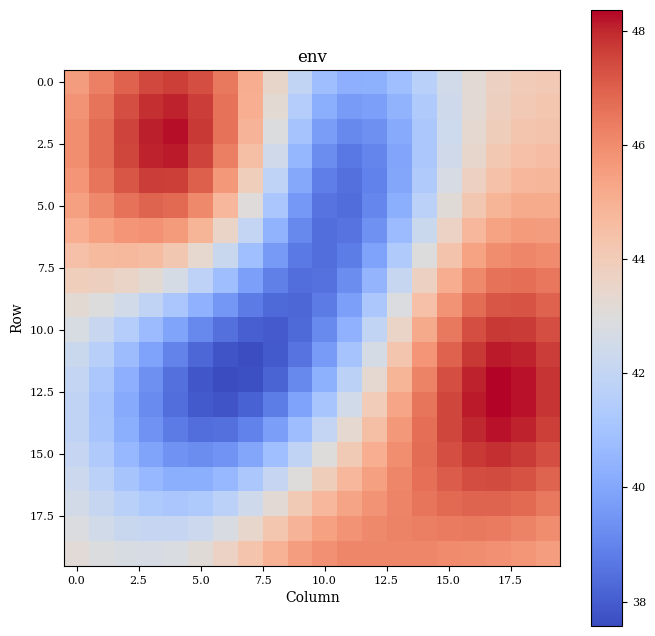

In [18]:
Setting.env_list.append(pred.copy())
# Create two subplots for env_list and mi_list heatmaps
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('env')
ax.set_xlabel('Column')
ax.set_ylabel('Row')
# Set axis limits for both subplots
ax.axis([-0.5, 19.5, -0.5, 19.5])
# Invert y-axis for both subplots
ax.invert_yaxis()
# Create heatmap objects for both subplots
heatmap3 = Setting.env_list[0]
im3 = ax.imshow(heatmap3, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
# Add colorbars to both subplots
cbar3 = fig.colorbar(im3, ax=ax)
# Define the size of the triangles
size = 0.3

In [19]:
# 使用数据作为初始状态
Setting.env = pred
# model_test = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
# Setting.env = model_test.solve(3)

In [20]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Experiment

In [21]:
#generate data
num_train = 0
num_change = Setting.R_change_interval
while num_train < Setting.max_num_samples:
    #change env
    if Setting.Env == "Dynamic":
        env_model = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
        Setting.env = env_model.solve(Setting.delta_t)

    Setting.env_list.append(Setting.env.copy())
    
    # change source
    if num_change >= Setting.R_change_interval:
        num_change = 0
        Setting.R = np.zeros((Setting.grid_x, Setting.grid_y))+4# initialize pollution resource map matrix
        if Setting.randomsource == True:
            # gengerate two set of random numbers for source locations
            numbers = rng.randint(0, 20, size=10)
            # while len(set(numbers)) == 1:
            #     numbers = rng.randint(0, 20, size=10)
            # while True:
            pairs = rng.choice(numbers, size=(5, 2), replace=False)
                # if not np.array_equal(pairs[0], pairs[1],):
                #     break  
            for i in range(5):
                number = rng.randint(100, 250, size=1)
                Setting.R[pairs[i,0]][pairs[i,1]] = number
        else:
            Setting.R[2][2] = 800
            Setting.R[17][17] = 800
            Setting.R[17][2] = 800
            Setting.R[2][17] = 800
    num_train = num_train + 1
    num_change = num_change + 1

100%|██████████| 0.1/0.1 [00:00<00:00,  2.94s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.52s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.51s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.42s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.48s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.49s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.51s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.54s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  3.88s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.52s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.51s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.54s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.50s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.52s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.52s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.52s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  3.84s/it]    
100%|██████████| 0.1/0.1 [00:00<00:00,  2.53s/it]    
100%|██████████| 0.1/0.1 [00

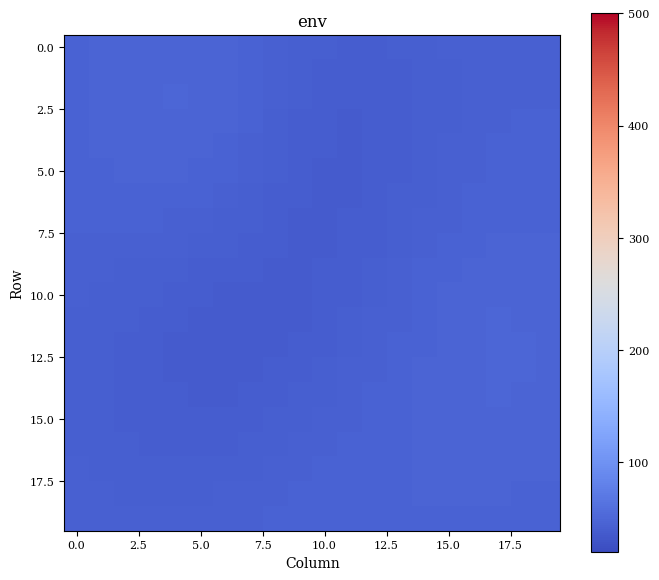

In [23]:
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import interpolate
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.colors as colors
# plot
# Define animate function for both subplots
# Create two subplots for env_list and mi_list heatmaps
fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))

ax1.set_title('env')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')

# Set axis limits for both subplots
ax1.axis([-0.5, 19.5, -0.5, 19.5])
# Invert y-axis for both subplots
ax1.invert_yaxis()
# Create heatmap objects for both subplots
heatmap1 = Setting.env_list[0]
im1 = ax1.imshow(heatmap1, cmap=cm.coolwarm, interpolation='nearest', origin='lower')
# Add colorbars to both subplots
cbar1 = fig.colorbar(im1, ax=ax1)
# Define animate function for both subplots
def animate(i):
    heatmap1 = Setting.env_list[i]
    im1.set_data(heatmap1)
    # Adjust the color range of the heatmap
    im1.set_clim(vmin=20, vmax=500)
    return im1

# Create animation object for both subplots
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = Setting.max_num_samples-1)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())